## 使用TensorFlow实现AHR

### 1、获取数据

源数据连接：
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

这些实验是在 19-48 岁年龄段的 30 名志愿者中进行的。每个人在腰部佩戴智能手机（Samsung Galaxy S II）进行六项活动（WALKING、WALKING_UPSTAIRS、WALKING_DOWNSTAIRS、SITTING、STANDING、LAYING）。使用其嵌入式加速度计和陀螺仪，我们以 50Hz 的恒定速率捕获 3 轴线性加速度和 3 轴角速度。实验已被录像以手动标记数据。获得的数据集被随机分成两组，其中 70% 的志愿者被选择用于生成训练数据和 30% 的测试数据。

传感器信号（加速度计和陀螺仪）通过应用噪声滤波器进行预处理，然后在 2.56 秒和 50% 重叠的固定宽度滑动窗口中进行采样（128 个读数/窗口）。具有重力和身体运动分量的传感器加速度信号使用巴特沃斯低通滤波器分离为身体加速度和重力。假设重力只有低频分量，因此使用了截止频率为 0.3 Hz 的滤波器。从每个窗口，通过从时域和频域计算变量来获得特征向量。

In [1]:
import numpy as np
import os
import pandas as pd

def get_data(filename, type):
    """ Read data
    Parm : filename : the input file name
    type : train or test

    Return the data in format data, label, channel of the data
    """
    path_ = os.path.join(filename, type )
    path_signals = os.path.join(path_, "Inertial Signals")

    sub_file = "y_" + type + ".txt"
    label_path = os.path.join(path_, sub_file)

    labels = pd.read_csv(label_path, header=None)

    channel_files = os.listdir(path_signals)
    channel_files.sort()
    n_channels = len(channel_files)
    posix = len(type) + 5

    list_of_channels = []
    data_array = np.zeros((len(labels), 128, n_channels))
    count = 0
    for filter_channel in channel_files:
        channel_name = filter_channel[:-posix]
        raw_data = pd.read_csv(os.path.join(path_signals, filter_channel), delim_whitespace=True, header=None)
        data_array[:, :, count] = raw_data.to_numpy()
        list_of_channels.append(channel_name)
        count += 1
    return data_array, labels[0].values, list_of_channels

In [26]:
    train_data, train_label, ch_train = get_data(filename="./UCI HAR Dataset/", type="train")
    test_data, test_label,ch_test = get_data(filename="./UCI HAR Dataset/", type="test")

In [27]:
print(ch_train,"\nTrain data shap:",train_data.shape,"train label shap:",train_label.shape)

['body_acc_x', 'body_acc_y', 'body_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z', 'total_acc_x', 'total_acc_y', 'total_acc_z'] 
Train data shap: (7352, 128, 9) train label shap: (7352,)


### 2、定义模型

In [28]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2), activation='relu', input_shape=X_train[0].shape),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units=64,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.001)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(units=6, activation='softmax')
                                    ])

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 127, 8, 64)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 4, 64)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 4, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 3, 64)         16448     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 1, 64)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 31, 1, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1984)             

### 3、预处理数据

In [29]:

def standardize(data):
	""" Standardize data """
	std_data = (data - np.mean(data, axis=0)[None,:,:]) / np.std(data, axis=0)[None,:,:]
	return std_data

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	return y


X_train = standardize(train_data)
X_test = standardize(test_data)

#train shape : (7352, 128, 9)
#test shape : (2947, 128, 9)

X_train = X_train.reshape(7352, 128, 9, 1)
X_test = X_test.reshape(2947, 128, 9, 1)

Y_train = one_hot(train_label, n_class = 6)
Y_test = one_hot(test_label, n_class = 6)
print(X_train[0].shape)

(128, 9, 1)


### 4、训练模型

In [15]:
history = model.fit(X_train, Y_train, epochs = 100, validation_data=(X_test, Y_test))

Epoch 1/100
230/230 [==============================] - 8s 35ms/step - loss: 1.1421 - acc: 0.4910 - val_loss: 0.8418 - val_acc: 0.5813
Epoch 2/100
230/230 [==============================] - 8s 34ms/step - loss: 0.7838 - acc: 0.6405 - val_loss: 0.6856 - val_acc: 0.6692
Epoch 3/100
230/230 [==============================] - 8s 34ms/step - loss: 0.6586 - acc: 0.7169 - val_loss: 0.6012 - val_acc: 0.7316
Epoch 4/100
230/230 [==============================] - 8s 34ms/step - loss: 0.5560 - acc: 0.7739 - val_loss: 0.4858 - val_acc: 0.7720
Epoch 5/100
230/230 [==============================] - 7s 32ms/step - loss: 0.4877 - acc: 0.8051 - val_loss: 0.4774 - val_acc: 0.8202
Epoch 6/100
230/230 [==============================] - 8s 34ms/step - loss: 0.4496 - acc: 0.8166 - val_loss: 0.4929 - val_acc: 0.8093
Epoch 7/100
230/230 [==============================] - 8s 33ms/step - loss: 0.4301 - acc: 0.8315 - val_loss: 0.4026 - val_acc: 0.8473
Epoch 8/100
230/230 [==============================] - 8s 34ms

### 5、输出训练结果

In [16]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['acc'])
    plt.plot(epoch_range, history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

  # Plot training & validation loss values
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

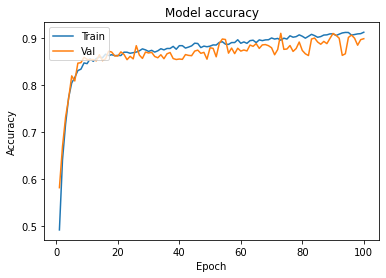

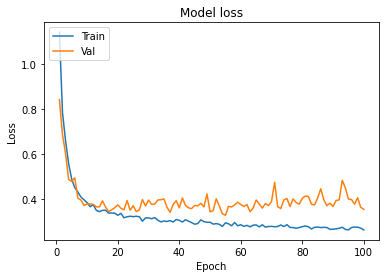

In [17]:
plot_learningCurve(history, 100)

### 6、保存最终的模型

In [19]:
model.save('my_model.h5')

### 7、重新加载模型测试保存的模型

In [20]:
new_model = tf.keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 8, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 4, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 4, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 3, 64)         16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 1, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 1, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1984)              0

In [23]:
loss, acc = new_model.evaluate(X_test, Y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

93/93 [==============================] - 1s 8ms/step - loss: 0.3529 - acc: 0.8996
Restored model, accuracy: 89.96%
